# Deep Convolutional Generative Adversarial Network

In [1]:
import tensorflow as tf

In [2]:
import numpy as np

## Load dataset

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
test_images.shape

(10000, 28, 28)

In [6]:
train_images = train_images.reshape(-1, 28, 28, 1).astype(np.float32)

In [7]:
test_images = test_images.reshape(-1, 28, 28, 1).astype(np.float32)

In [8]:
train_images = (train_images-127.5)/127.5

### Create mini-batch

In [9]:
def get_batch(x, y=None, batch_size=32, epochs=1, shuffle=True):
    if y is None:
        dataset = tf.data.Dataset.from_tensor_slices(x)
    else:
        dataset = tf.data.Dataset.from_tensor_slices((x, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(x))
    dataset = dataset.batch(batch_size).repeat(epochs)
    return dataset.make_one_shot_iterator().get_next()

## Build model

In [10]:
from keras import Sequential

Using TensorFlow backend.


In [11]:
from keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape
from keras.layers import Conv2DTranspose, Conv2D, Dropout, Flatten

### Input

In [12]:
noise_dim = 100

noise = tf.placeholder(tf.float32, shape=[None, noise_dim])
targets = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])

### Generator model

In [13]:
def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same',
                              use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

### Discriminator model

In [14]:
def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(1))
    
    return model

In [15]:
with tf.name_scope('generator'):
    generator = make_generator_model()
    generated_images = generator(noise)
with tf.name_scope('discriminator'):
    discriminator = make_discriminator_model()
    generated_logits = discriminator(generated_images)
    target_logits = discriminator(targets)

### Loss function

#### The generator loss 

Since we want the generator to generate pictures close to real pictures, we need to optimize the generator parameters so that the discrimintor think those generated pictures are real picture, which means the discriminator outputs 1 for the generated pictures. Thus the generator loss is a sigmoid cross entropy loss of the generated images and an array of ones.

In [16]:
# generator_loss
gen_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(generated_logits),
                                                  logits=generated_logits)
gen_loss = tf.reduce_mean(gen_loss)

#### The discriminator loss

We want the discriminators able to distinguish fake images from real images. Fake images should be labeled as zeros, and real images should be labeled as ones. And combined the two erros together.

In [17]:
real_error = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(target_logits),
                                                    logits=target_logits)
fake_error = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(generated_logits),
                                                    logits=generated_logits)
real_error = tf.reduce_mean(real_error)
fake_error = tf.reduce_mean(fake_error)
dis_loss = real_error+fake_error

### Define Optimizer

In [18]:
gen_var_list = tf.trainable_variables(scope='generator')
dis_var_list = tf.trainable_variables(scope='discriminator')

In [19]:
gen_grads = tf.gradients(gen_loss, gen_var_list)
dis_grads = tf.gradients(dis_loss, dis_var_list)

In [20]:
gen_train = tf.train.AdamOptimizer(1e-4).apply_gradients(zip(gen_grads, gen_var_list))
dis_train = tf.train.AdamOptimizer(1e-4).apply_gradients(zip(dis_grads, dis_var_list))

## Train

In [21]:
epochs = 2
batch_size = 32
max_iter = 500000
x_batch = get_batch(train_images, batch_size=batch_size, epochs=epochs, shuffle=True)
saver = tf.train.Saver()
with tf.Session() as sess:
    n_iter = 0
    sess.run(tf.global_variables_initializer())
    try:
        while n_iter < max_iter:
            random_noise = np.random.normal(size=(batch_size, noise_dim))
            real_images = sess.run(x_batch)
            loss1, _ = sess.run([gen_loss, gen_train], {noise: random_noise})
            loss2, _ = sess.run([dis_loss, dis_train], 
                                {noise: random_noise, targets: real_images})
            if n_iter%100 == 0:
                print('Iteration %d, generator loss: %f, discriminator loss: %f' 
                      %(n_iter, loss1, loss2))
            n_iter += 1
    except tf.errors.OutOfRangeError:
        print('---Read All Epochs---')
    print('---Training Ends---')
    saver.save(sess, 'checkpoints/DCGAN.ckpt')

Iteration 0, generator loss: 0.692550, discriminator loss: 1.383406
Iteration 100, generator loss: 0.502349, discriminator loss: 1.192763
Iteration 200, generator loss: 1.636345, discriminator loss: 0.596447
Iteration 300, generator loss: 1.159016, discriminator loss: 0.869216
Iteration 400, generator loss: 0.971280, discriminator loss: 1.271450
Iteration 500, generator loss: 1.111439, discriminator loss: 1.635183
Iteration 600, generator loss: 1.645658, discriminator loss: 0.592239
Iteration 700, generator loss: 1.314601, discriminator loss: 1.103094
Iteration 800, generator loss: 3.179282, discriminator loss: 0.115883
Iteration 900, generator loss: 2.022287, discriminator loss: 0.511514
Iteration 1000, generator loss: 1.909041, discriminator loss: 0.845537
Iteration 1100, generator loss: 2.175731, discriminator loss: 0.456648
Iteration 1200, generator loss: 1.755713, discriminator loss: 0.723967
Iteration 1300, generator loss: 2.674845, discriminator loss: 0.288647
Iteration 1400, ge

## Generate

In [22]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    random_noise = np.random.normal(size=(1, noise_dim))
    temp = sess.run(generated_images, {noise: random_noise})

INFO:tensorflow:Restoring parameters from checkpoints/DCGAN.ckpt


### Show image

In [23]:
import matplotlib.pyplot as plt

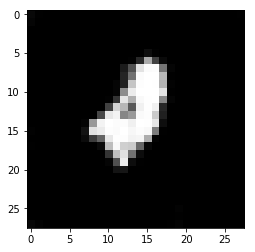

In [24]:
plt.imshow(temp[0, :, :, 0]*127.5+127.5, cmap='gray')

Only after 2 epochs, we can see that the generated images looks something like real images